In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from pyoperators import MPI

import qubic
from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Calibration.Qselfcal import scatter_plot_FP, get_TEScoordinates_ONAFP
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Instrument.Qacquisition import QubicMultiAcquisitions
from qubic.lib.Qsamplings import get_pointing

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
nside = 128

# Initialize QUBIC Instance

Build the QUBIC dictionary, mandatory to use the QUBIC functions

In [3]:
def get_dict(comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": 1,
        "nf_recon": 2,
        "nf_sub": 20,
        "nside": nside,
        "MultiBand": True,
        "period": 1,
        "RA_center": 0,
        "DEC_center": -57,
        "filter_nu": 150 * 1e9,
        "noiseless": True,
        "comm": comm,
        "dtheta": 15,
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": False,
        "nhwp_angles": 1,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(4.7e-17),
        "synthbeam_kmax": 1,
        "synthbeam_fraction": 1,
        "beam_shape": "gaussian",
        "debug":False,
        "kind": "IQU",
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic

In [4]:
# Build MPI communicator and qubic dict
comm = MPI.COMM_WORLD
dict_qubic = get_dict(comm)

In [5]:
dict_qubic["use_synthbeam_fits_file"] = False

In [6]:
# Build scanning strategy
sampling = get_pointing(dict_qubic)

# Build QubicInstrument
q = QubicInstrument(dict_qubic)

You asked 1 pointings with repeat strategy so I will provide 1 pointings repeated 1 times.
150000000000.0
executing: self.detarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'


In [7]:
# Number of sub-acquisitions
nsub = 6

In [8]:
# Initialize the Qubic multi-frequency acquisition
# I multiply by 2 Nsub to have Nsub bands in each band, the rest of the code will only use the first Nsub bands (meaning the ones in the 150 GHz band)
acq = QubicMultiAcquisitions(dict_qubic, nsub*2, 2, sampling=sampling)

# Build a list that contains all sub-ProjectionOperators, meaning the ProjectionOperators for each sub-bands
Proj_list = []
for i in range(nsub):
    Proj_list.append(acq.subacqs[i].get_projection_operator())

134057130532.38887
executing: self.detarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
139791467510.70367
executing: self.detarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/laclavere/Documents/Thesi

# Plot Synthesized Beam

Plot the shape of the beams

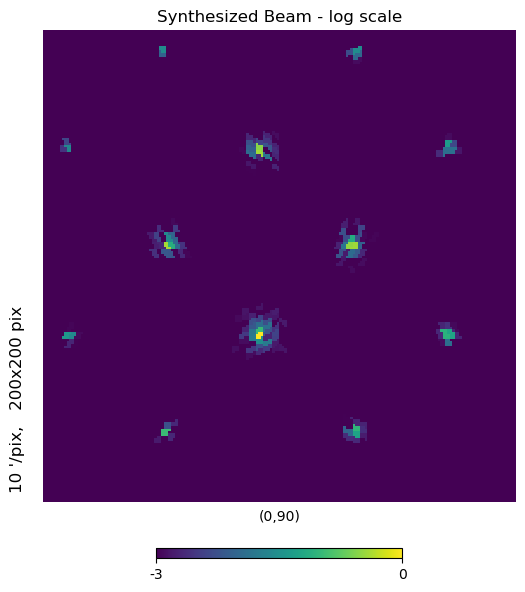

In [9]:
sb = acq.subacqs[0].instrument[210].get_synthbeam(acq.subacqs[0].scene)[0]
hp.gnomview(np.log10(sb/np.max(sb)), rot=[0,90], reso=10, min=-3, title="Synthesized Beam - log scale")

In [10]:
# This is the analytical synthesized for a pixel at the focal plane center 
# without accounting for the primary beam (just the mukltple peaks)
# def sb_noprim(th_deg, nu):
#     th = np.radians(th_deg)
#     lam = 3e8/nu
#     P = 20
#     deltax = 0.013
#     abscissa = np.pi * deltax/lam * th
#     sb = np.sin(P*abscissa)**2 / np.sin(abscissa)**2
#     return sb/np.max(sb)

# N = 5000
# thetas = np.linspace(-30, 30, N)
# phis = 0
# prim_beam = np.zeros((nsub, N))
# thetas_peak = []
# thetas_test = np.linspace(-15, -5, N)

# colors = ['blue', 'red', 'green', 'orange']
# plt.figure(figsize=(10, 8))
# for i in range(nsub):
#     prim_beam[i] = acq.multiinstrument[i].primary_beam(np.radians(np.abs(thetas)), phis)
#     ind_peak = np.where((prim_beam[i]*sb_noprim(thetas_test, acq.allnus[i]*1e9)) == np.max(prim_beam[i]*sb_noprim(thetas_test, acq.allnus[i]*1e9)))[0]
#     thetas_peak.append(thetas_test[ind_peak])
#     plt.plot(thetas, prim_beam[i], '--', color = colors[i], label='Prim. Beam - nu={0:6.1f} GHz'.format(acq.allnus[i]))
#     plt.plot(thetas, prim_beam[i] * sb_noprim(thetas, acq.allnus[i]*1e9), color = colors[i], label='Synth. Beam - nu={0:6.1f} GHz'.format(acq.allnus[i]))
# plt.xlim(-20, 20)
# plt.xlabel('$\\theta$ [deg]')
# plt.ylabel('Normalized beam')
# plt.legend()

# Plot Primary and Synthesized Beams

In [11]:
idet = 204

# Compute Synthetisized Beam for a given detector 
synth = acq.multiinstrument[0].get_synthbeam(acq.scene)[idet]

npix = hp.nside2npix(nside)
prim_beam = np.zeros(npix)

# Compute Primary Beam
prim = acq.multiinstrument[0].primary_beam
for i in range(npix):
    theta, phi = hp.pix2ang(nside, i)
    prim_beam[i] = prim(theta, phi)

In [12]:
# Compute the position of the secondary peaks using _peak_angles_kmax
th, ph = acq.subacqs[0].instrument._peak_angles_kmax(acq.subacqs[0].instrument.synthbeam.kmax, 
                                                     acq.subacqs[0].instrument.horn.spacing, 
                                                     acq.subacqs[0].instrument.horn.angle, 
                                                     acq.subacqs[0].instrument.filter.nu, 
                                                     acq.subacqs[0].instrument.detector.center)
# Compute the amplitude of each peaks
val = np.array(prim(th, ph), dtype=float, copy=False)

In [13]:
# Compute the position and the amplitude of the secondary peaks using _peak_angles
# This function uses _peak_angles_kmax
thetas, phis, vals = acq.subacqs[0].instrument._peak_angles(acq.scene, acq.allnus[0]*1e9, 
                                    acq.subacqs[0].instrument.detector.center,
                                    acq.subacqs[0].instrument.synthbeam,
                                    acq.subacqs[0].instrument.horn,
                                    acq.subacqs[0].instrument.primary_beam)

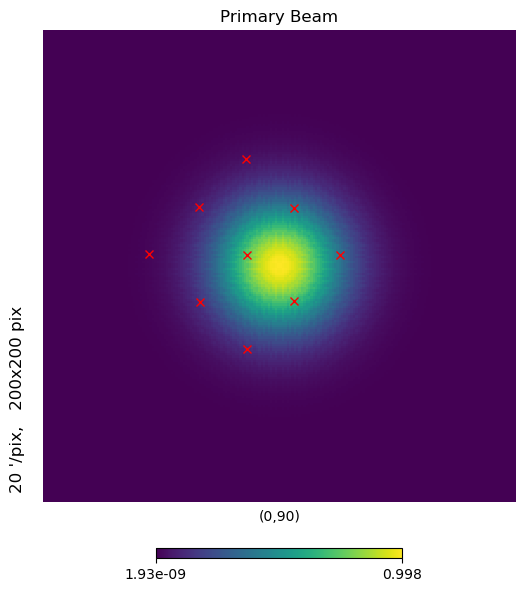

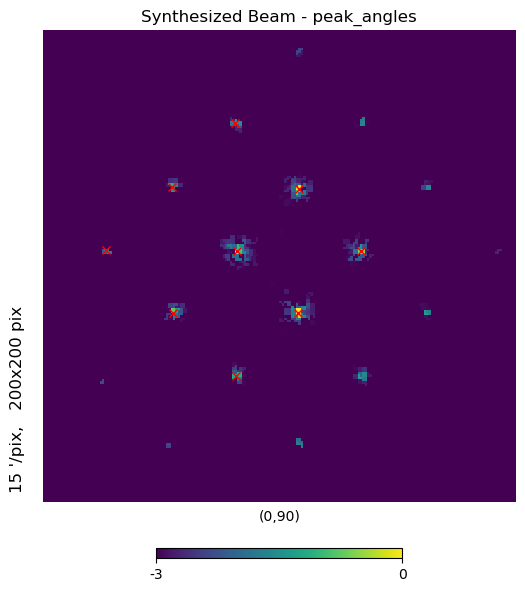

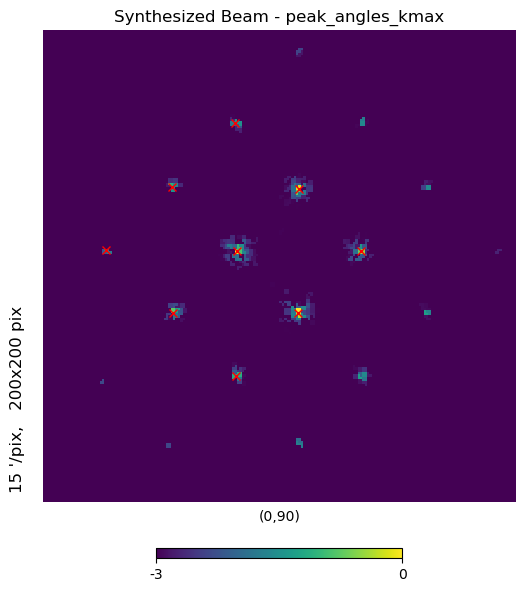

In [14]:
# Compare the result, to see if these functions compute properly the peak position
hp.gnomview(prim_beam, rot=[0,90], reso=20, title="Primary Beam")
hp.projplot(thetas[idet], phis[idet], 'rx', lonlat=False)
hp.gnomview(np.log10(synth/np.max(synth)), rot=[0, 90], min=-3, reso=15, title="Synthesized Beam - peak_angles")
hp.projplot(thetas[idet], phis[idet], 'rx', lonlat=False)
hp.gnomview(np.log10(synth/np.max(synth)), rot=[0, 90], min=-3, reso=15, title="Synthesized Beam - peak_angles_kmax")
hp.projplot(th[idet], ph[idet], 'rx', lonlat=False)

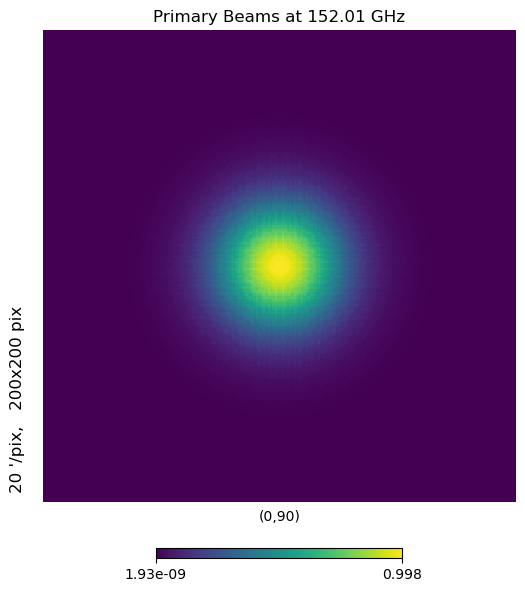

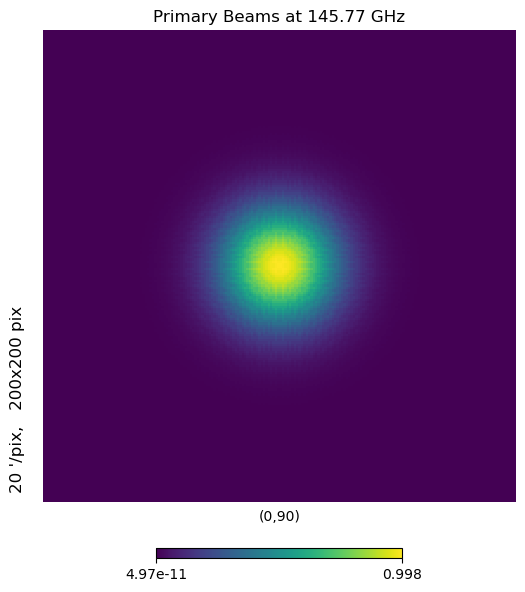

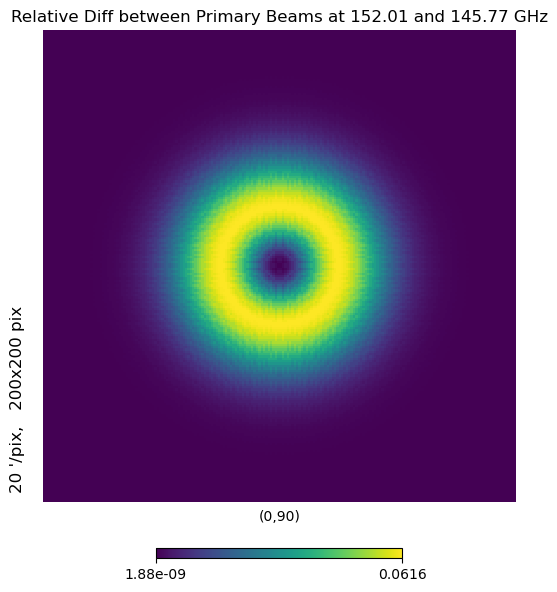

In [15]:
# Relative diff between primary beams
ind_a, ind_b = 3, 2

prim_a = acq.multiinstrument[ind_a].primary_beam
prim_b  = acq.multiinstrument[ind_b].primary_beam

npix = hp.nside2npix(nside)
prim_beam_a = np.zeros(npix)
prim_beam_b = np.zeros(npix)

for i in range(npix):
    theta, phi = hp.pix2ang(nside, i)
    prim_beam_a[i] = prim(theta, phi)
    prim_beam_b[i] = prim_b(theta, phi)

hp.gnomview(prim_beam_a, rot=[0,90], reso=20, title=f"Primary Beams at {acq.allnus[ind_a].round(2)} GHz")
hp.gnomview(prim_beam_b, rot=[0,90], reso=20, title=f"Primary Beams at {acq.allnus[ind_b].round(2)} GHz")

hp.gnomview((prim_beam_a - prim_beam_b), rot=[0,90], reso=20, title=f"Relative Diff between Primary Beams at {acq.allnus[ind_a].round(2)} and {acq.allnus[ind_b].round(2)} GHz")

# Compare Primary and Synthesized Beams evolution with frequency

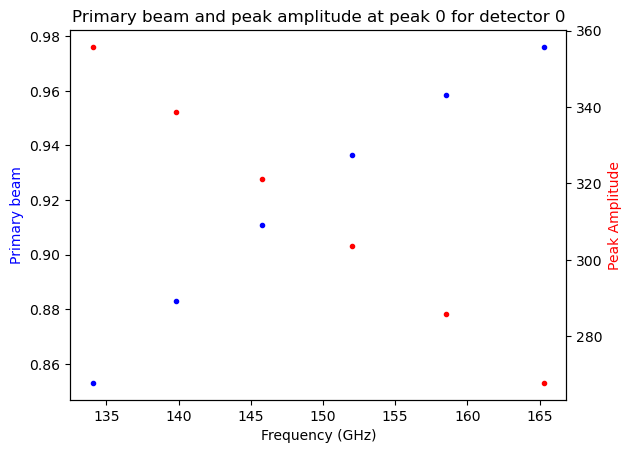

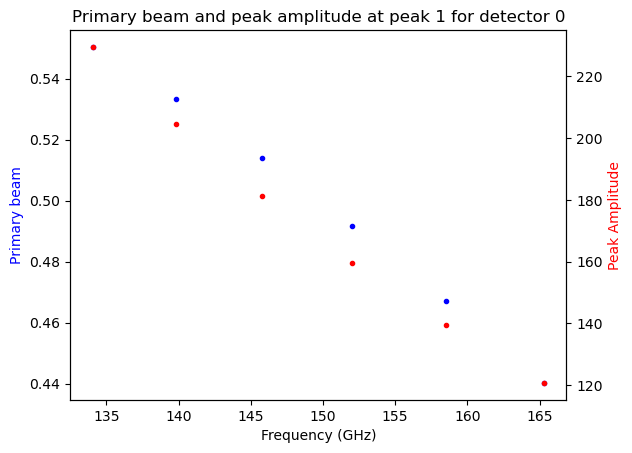

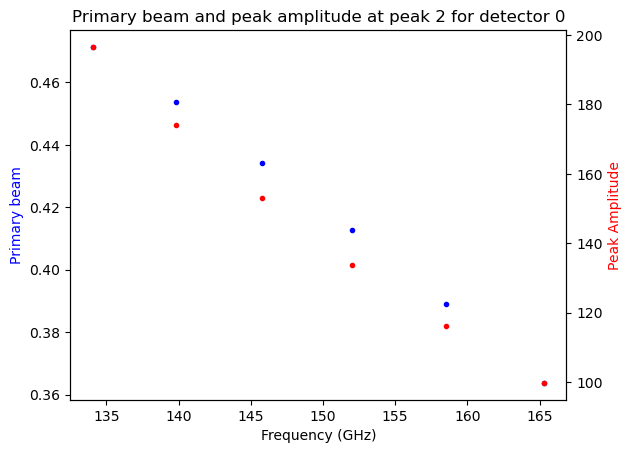

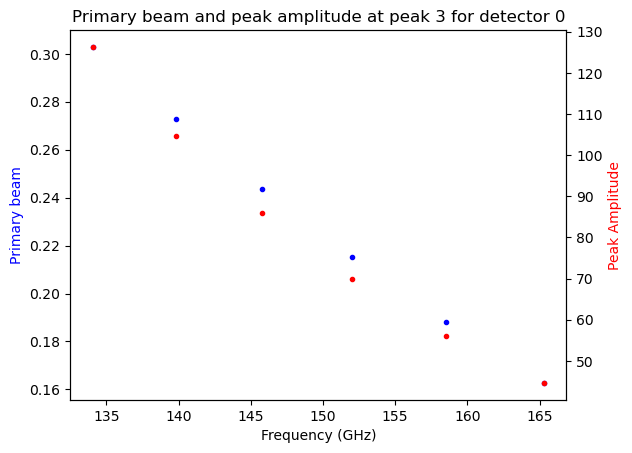

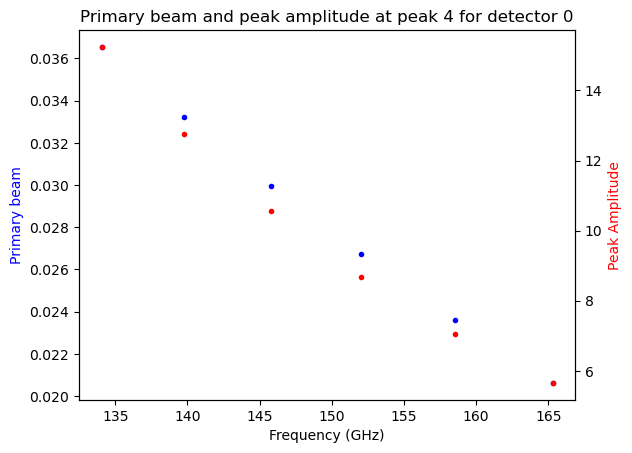

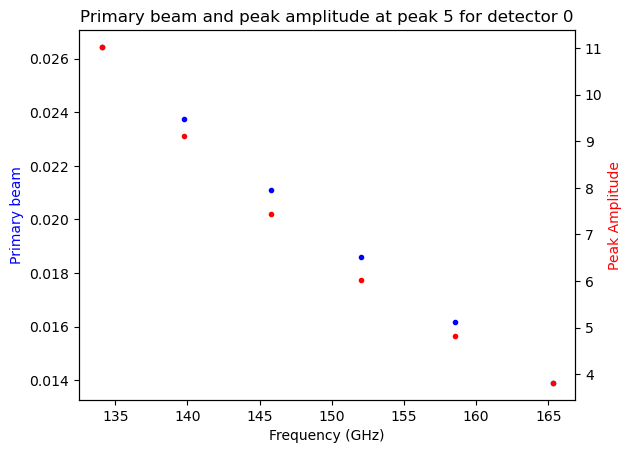

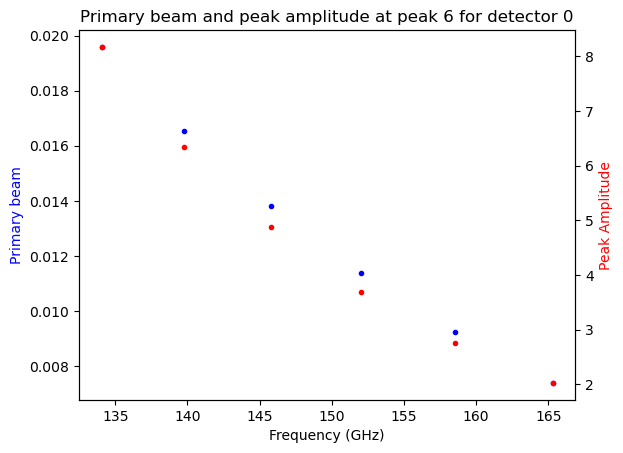

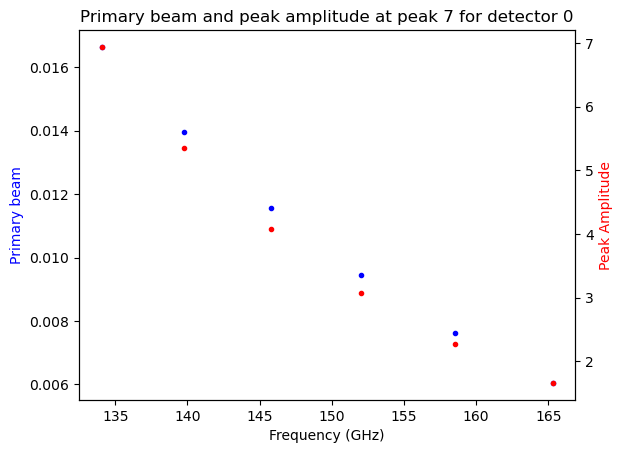

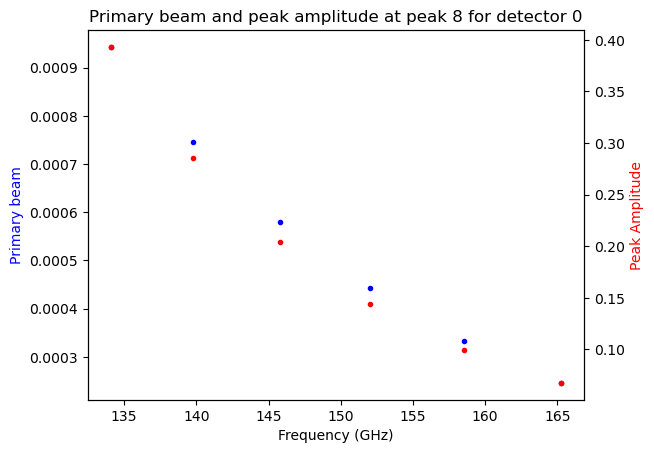

In [16]:
idet = 0
N_sample = 0
time_index = 0

for ipeak in range(thetas.shape[1]):
    peak_amplitude = [] 
    fig, ax1 = plt.subplots()

    prim_freq = [acq.multiinstrument[i].primary_beam for i in range(nsub)]

    for i in range(nsub):
        th, ph, v = acq.subacqs[i].instrument._peak_angles(acq.scene, acq.allnus[i]*1e9, 
                                        acq.subacqs[i].instrument.detector.center,
                                        acq.subacqs[i].instrument.synthbeam,
                                        acq.subacqs[i].instrument.horn,
                                        acq.subacqs[i].instrument.primary_beam)

        ax1.plot(acq.allnus[i], prim_freq[i](th[idet, ipeak], ph[idet, ipeak]), '.b')
           
        peak_amplitude.append(Proj_list[i].matrix.data.r11[(idet*N_sample)+time_index, ipeak])

    ax1.set_xlabel('Frequency (GHz)')
    ax1.set_ylabel('Primary beam', color = 'blue')
    ax1.set_title('Primary beam and peak amplitude at peak %d for detector %d' % (ipeak, idet))

    ax2 = ax1.twinx()
    ax2.plot(acq.allnus[:nsub], peak_amplitude, '.r')
    ax2.set_ylabel("Peak Amplitude", color = 'r')
    plt.show()

# Build TOD

In [17]:
# Create uniform maps of "1"
input_maps = np.ones((nsub, hp.nside2npix(nside), 3))
input_maps[..., 1] *= 0 

# Build the list of sub-TODs
tod = []
for i in range(nsub):
    tod.append(Proj_list[i](input_maps[i]))

In [18]:
print(tod[0].shape)

(992, 1, 3)


# Relative difference between succesive sub-TODs

Text(0.5, 0, 'Frequency (GHz)')

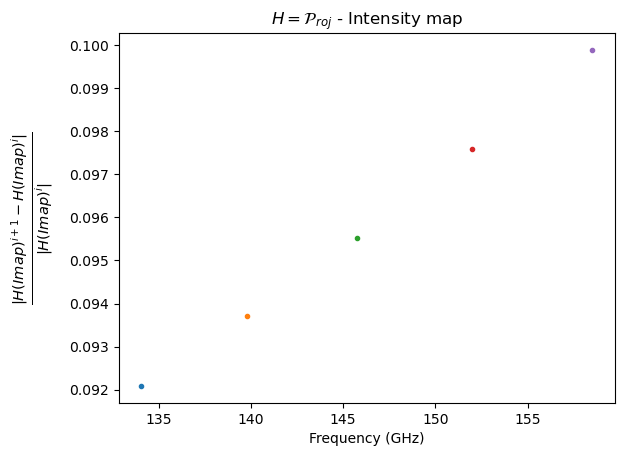

In [19]:
plt.figure()
for i in range(nsub-1):
    diff = np.abs((tod[i+1][:, 0, 0] - tod[i][:, 0, 0])/tod[i][:, 0, 0])
    # Need to remove 'nan' due to division by 0
    # Mean on detectors
    mean_diff = np.mean(diff[~np.isnan(diff)])
    plt.plot(acq.allnus[i], mean_diff, '.')
plt.title(r"$H = \mathcal{P}_{roj}$ - Intensity map")
plt.ylabel(r'$\frac{| H(Imap)^{i+1} - H(Imap)^i |}{| H(Imap)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')

Text(0.5, 0, 'Frequency (GHz)')

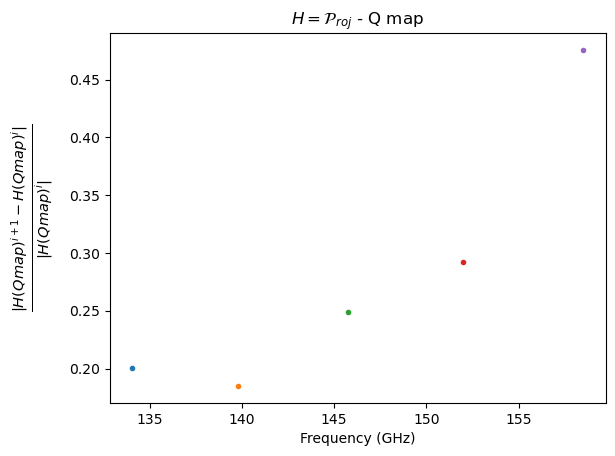

In [20]:
plt.figure()
for i in range(nsub-1):
    diff = np.abs((tod[i+1][:, 0, 1] - tod[i][:, 0, 1])/tod[i][:, 0, 1])
    # Need to remove 'nan' due to division by 0
    # Mean on detectors
    mean_diff = np.mean(diff[~np.isnan(diff)])
    plt.plot(acq.allnus[i], mean_diff, '.')
plt.title(r"$H = \mathcal{P}_{roj}$ - Q map")
plt.ylabel(r'$\frac{| H(Qmap)^{i+1} - H(Qmap)^i |}{| H(Qmap)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')

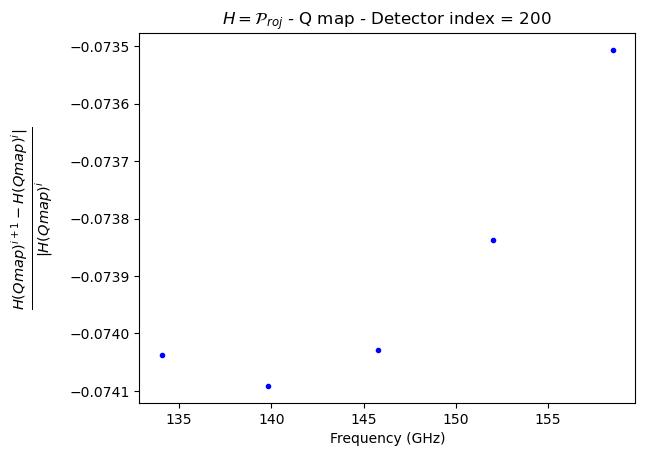

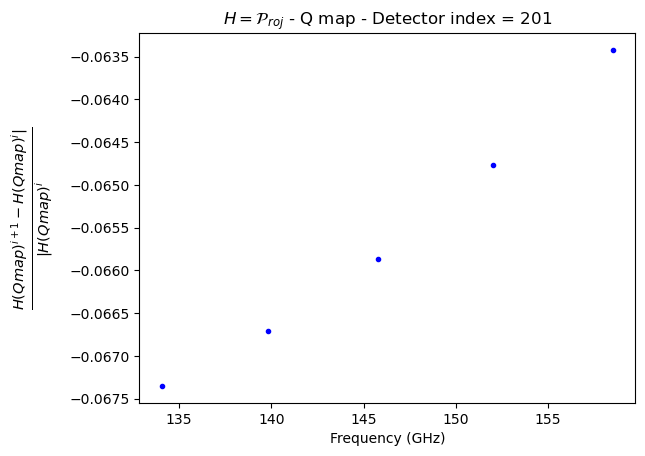

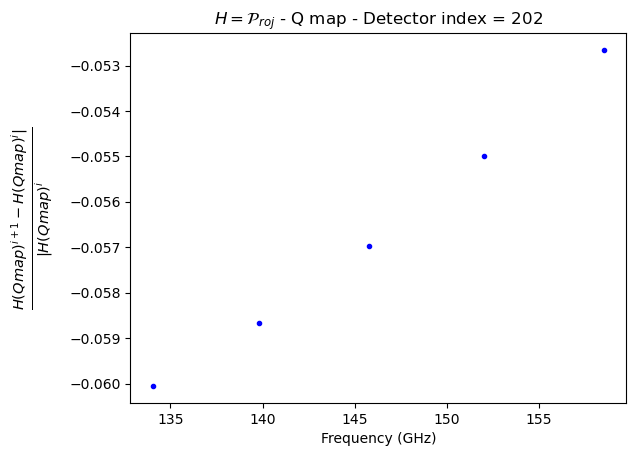

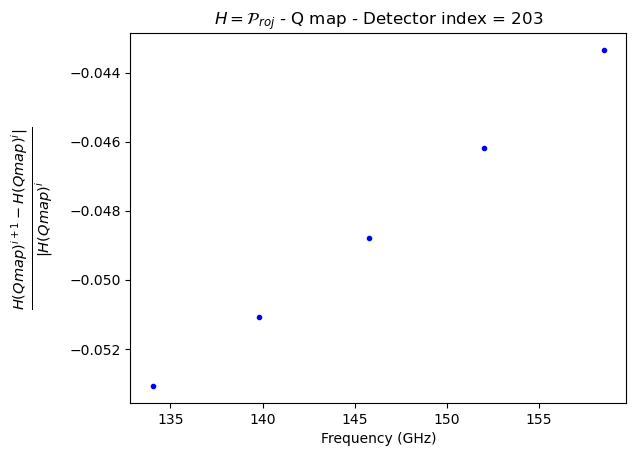

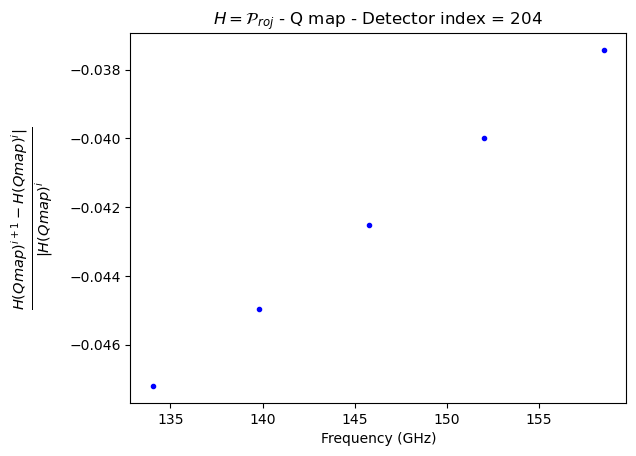

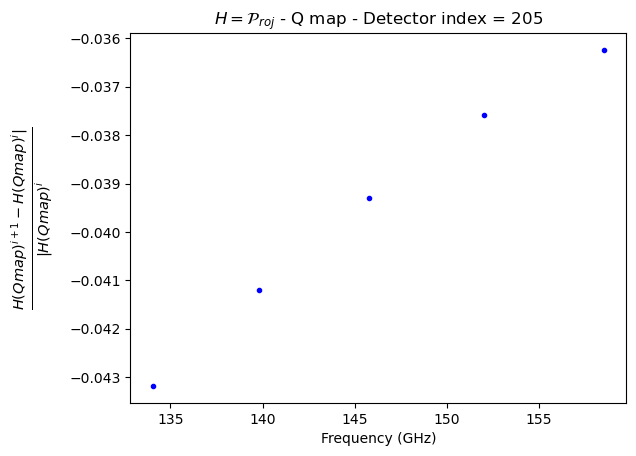

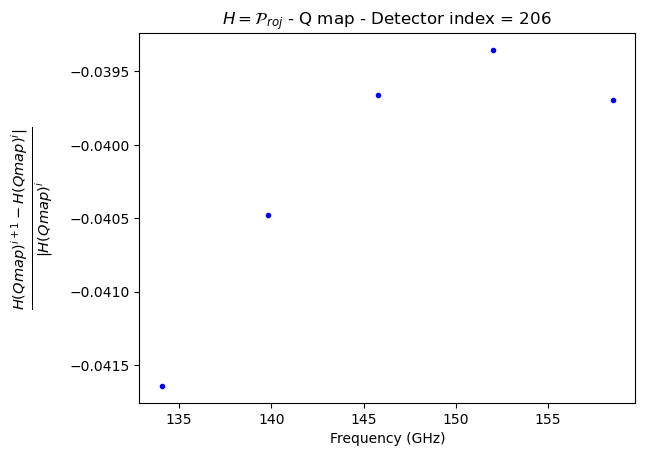

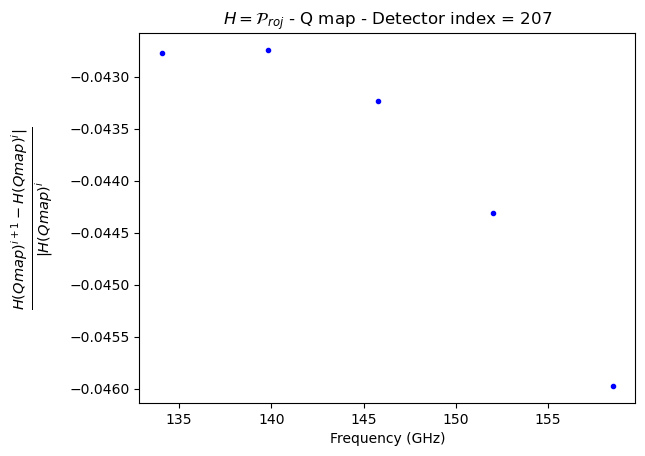

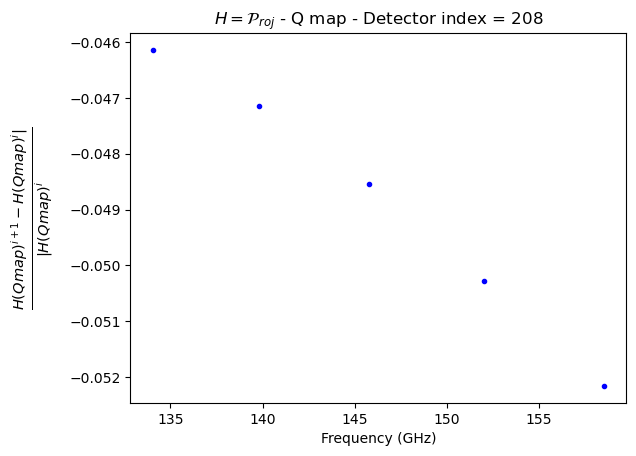

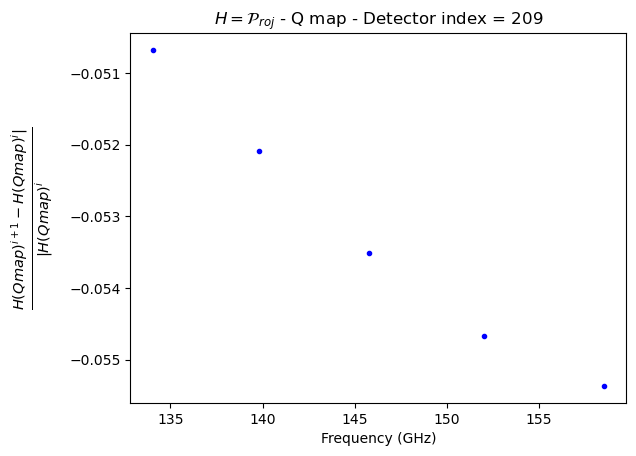

In [21]:
plt.figure()
idet = 245
for idet in range(200, 210):
    for i in range(nsub-1):
        diff = (tod[i+1][idet, 0, 1] - tod[i][idet, 0, 1])/tod[i][idet, 0, 1]#np.abs((tod[i+1][idet, 0, 1] - tod[i][idet, 0, 1])/tod[i][idet, 0, 1])
        plt.plot(acq.allnus[i], diff, '.b')
    plt.title(r"$H = \mathcal{P}_{roj}$ - Q map - " + f'Detector index = {idet}')
    plt.ylabel(r'$\frac{ H(Qmap)^{i+1} - H(Qmap)^i |}{| H(Qmap)^{i}}$', fontsize=15, labelpad=10)
    plt.xlabel('Frequency (GHz)')
    plt.show()

# Relative difference on the focal plane

Plot the difference between two successive tods, at a given time, on the focal plane. The polarisation case seems very strange with respect to the intensity case.

In [22]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)

In [23]:
print(tod[0].shape)

(992, 1, 3)


(992, 1, 3)


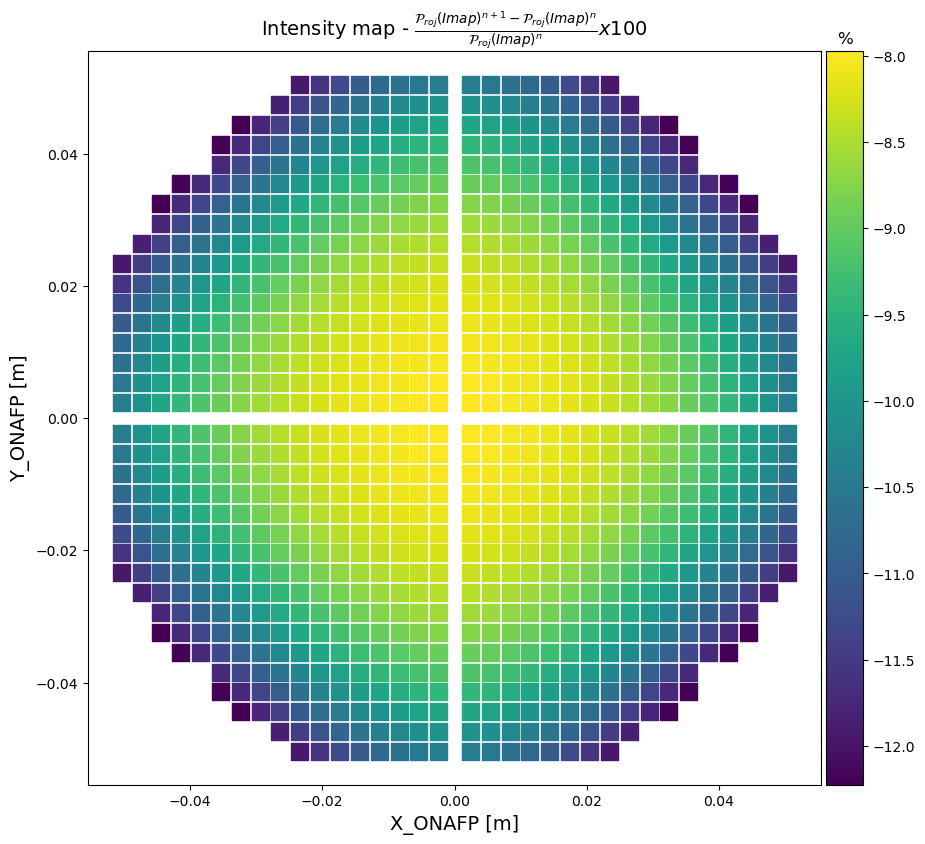

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
ind_a, ind_b = 3, 2
relative_diff = (tod[ind_a]-tod[ind_b])/tod[ind_b]*100
print(relative_diff.shape)
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff[...,0], axis=1), frame='ONAFP', s=150, title=r'Intensity map - $\frac{ \mathcal{P}_{roj}(Imap)^{n+1} - \mathcal{P}_{roj}(Imap)^{n} }{ \mathcal{P}_{roj}(Imap)^{n} } x 100$', fig=fig, ax = ax, unit='%')

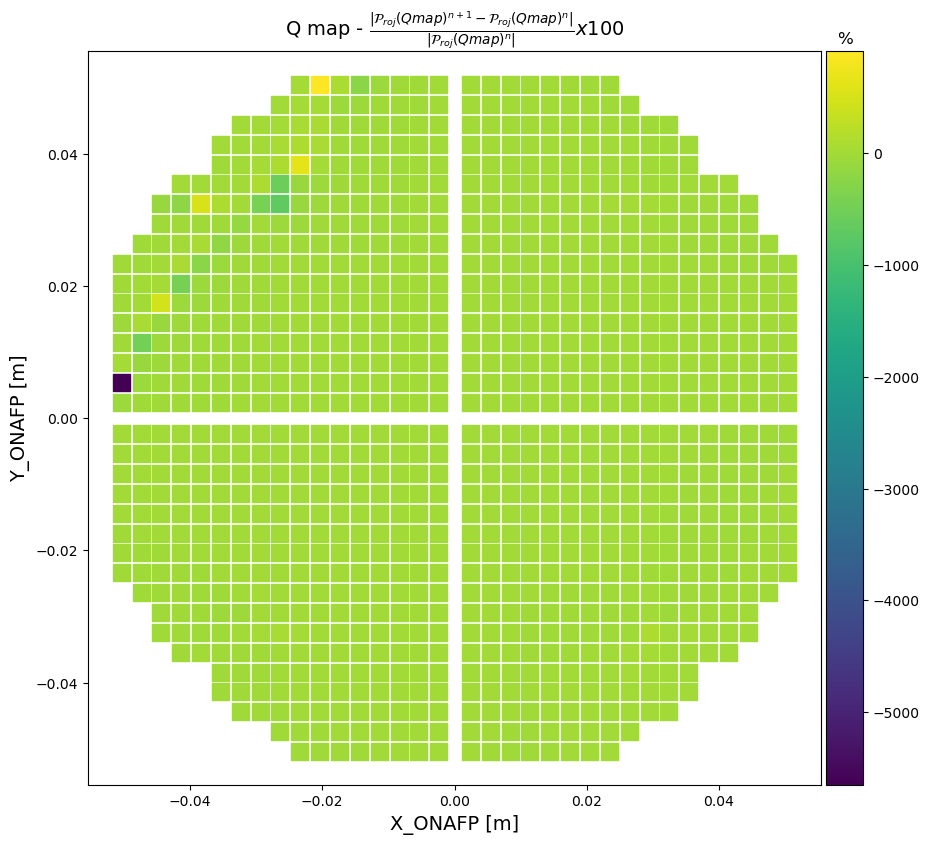

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = (tod[ind_a]-tod[ind_b])/tod[ind_b]*100
scatter_plot_FP(q, xTES, yTES, relative_diff[:, 0, 1], frame='ONAFP', s=150, title=r'Q map - $\frac{| \mathcal{P}_{roj}(Qmap)^{n+1} - \mathcal{P}_{roj}(Qmap)^{n} |}{| \mathcal{P}_{roj}(Qmap)^{n} |} x 100$', fig=fig, ax = ax, unit='%')

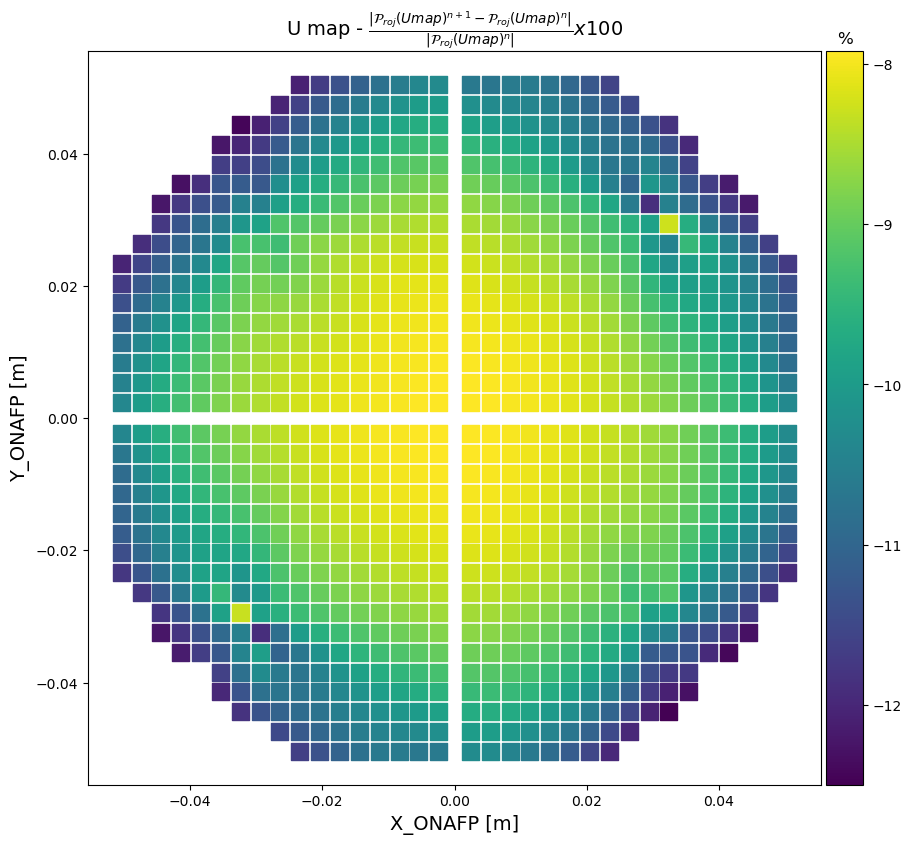

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = (tod[ind_a]-tod[ind_b])/tod[ind_b]*100
scatter_plot_FP(q, xTES, yTES, relative_diff[:, 0, 2], frame='ONAFP', s=150, title=r'U map - $\frac{| \mathcal{P}_{roj}(Umap)^{n+1} - \mathcal{P}_{roj}(Umap)^{n} |}{| \mathcal{P}_{roj}(Umap)^{n} |} x 100$', fig=fig, ax = ax, unit='%')

# Projection angle

In [27]:
P = Proj_list[-1]

alpha_from_r22 = 0.5 * np.arccos(P.matrix.data.r22 / P.matrix.data.r11)
alpha_from_r32 = 0.5 * np.arcsin(- P.matrix.data.r32 / P.matrix.data.r11)

cos2_sin2 = (P.matrix.data.r22**2 + P.matrix.data.r32**2) / P.matrix.data.r11**2

In [28]:
cos2_sin2[0]

array([1.        , 1.        , 0.9999999 , 1.0000001 , 1.        ,
       1.        , 1.        , 0.99999994, 1.0000001 ], dtype=float32)

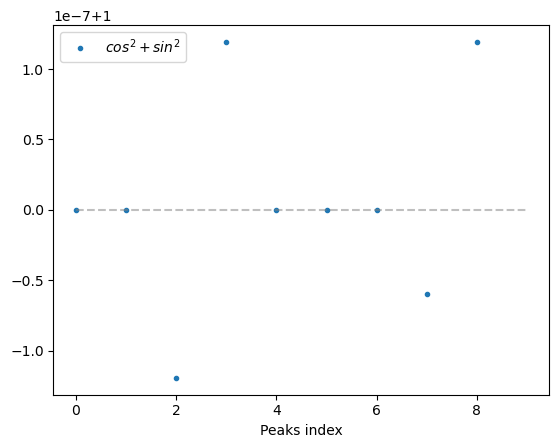

In [29]:
plt.plot(cos2_sin2[0], '.', label=r'$cos^2 + sin^2$')
plt.hlines(1, 0, (2*dict_qubic['synthbeam_kmax'] + 1)**2, 'grey', linestyle='--', alpha=0.5)
plt.xlabel('Peaks index')
plt.legend()

# Peak Amplitude evolution with frequency

P.matrix.data is build such that you have all the points for the same detector at all the different time samples, then the next detector at all the different time samples, etc.

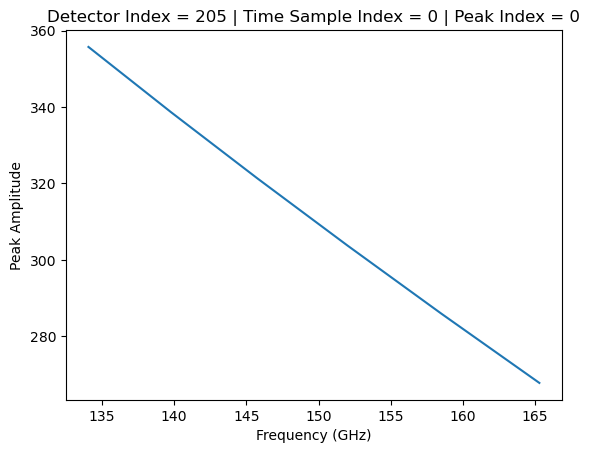

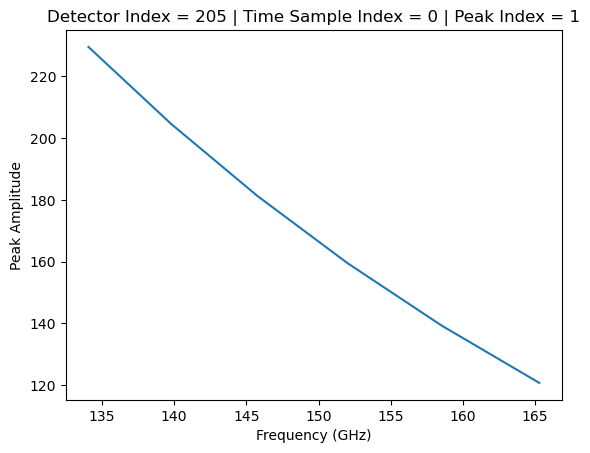

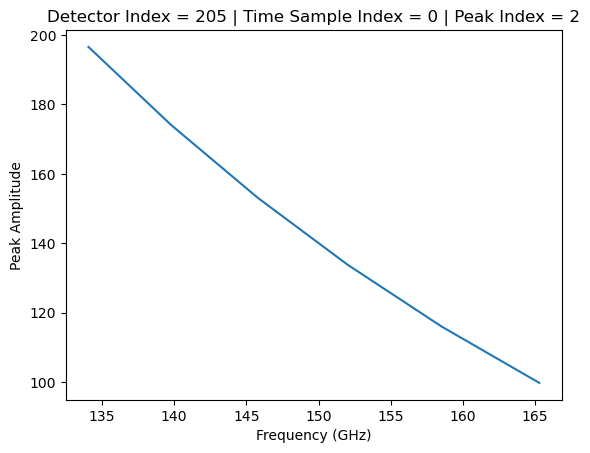

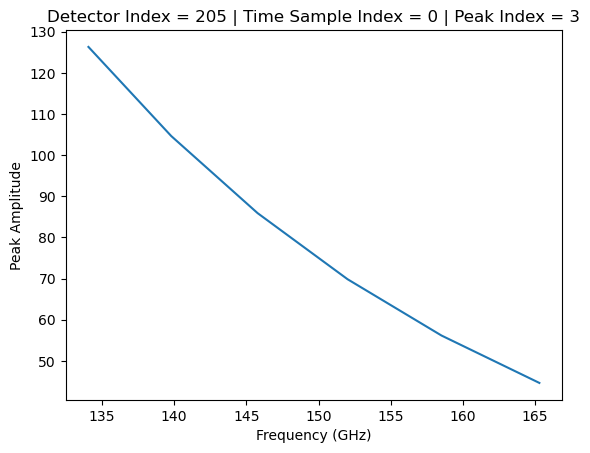

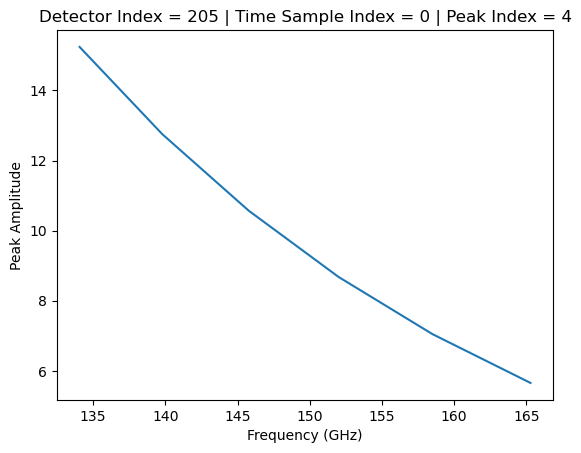

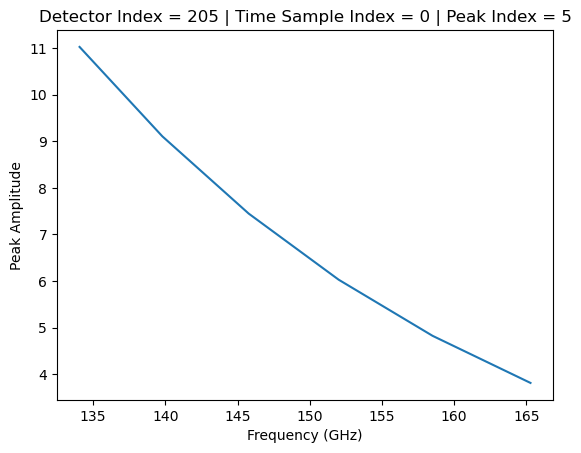

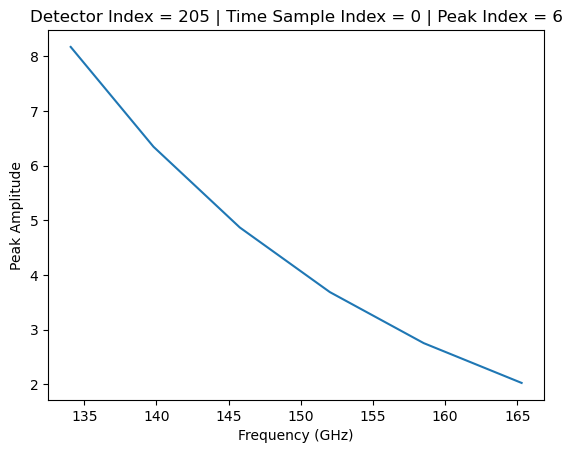

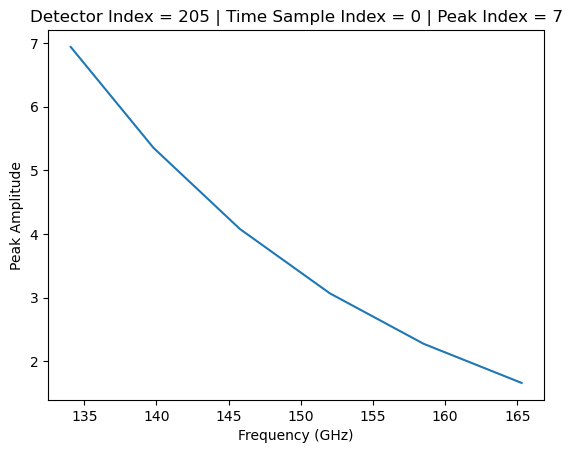

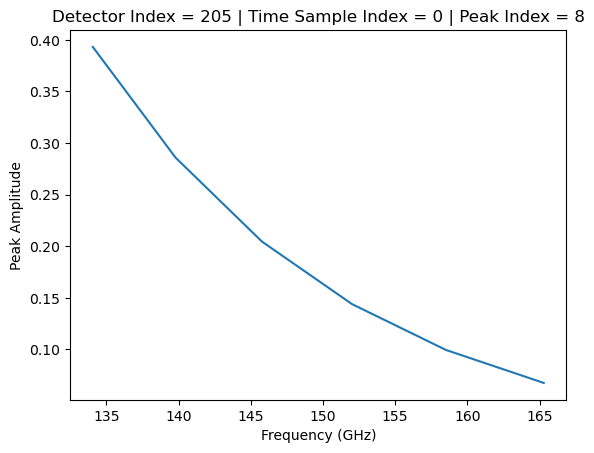

In [30]:
peak_index = 0
N_sample = 0
time_index = 0
det_index = 205
for peak_index in range((2*dict_qubic['synthbeam_kmax']+1)**2):
    plt.figure()
    peak_amplitude = []
    for i in range(nsub):
        peak_amplitude.append(Proj_list[i].matrix.data.r11[(det_index*N_sample)+time_index, peak_index])

    plt.plot(acq.allnus[:nsub], peak_amplitude)
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Peak Amplitude")
    plt.title(f"Detector Index = {det_index} | Time Sample Index = {time_index} | Peak Index = {peak_index}")
    plt.show()